In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# 연비 예측 딥러닝 모델 구현
- 실린더 수, 배기량, 마력, 공차 중량 등을 사용하여 MPG 연비를 예측 하는 회귀 모델을 구현
- 수치 예측

# 라이브러리 로드

In [2]:
from tensorflow.keras.datasets import mnist             # Modified National Institute of Standards and Technology database
import matplotlib.pyplot as plt                         # 시각화를 위한 라이브러리
import numpy as np                                      # 연산 등을 위한 라이브러리
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Input, Dense, Dropout    # Tensorflow 모델 구성을 위한 라이브러리
from tensorflow.keras.models import Model
import tensorflow as tf

from sklearn.model_selection import train_test_split         # 데이터 전처리를 위한 라이브러리
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 데이터 로드

In [3]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()


# 데이터 확인

## 결측 데이터 확인 & 제거

In [4]:
print(dataset.isnull().sum())
dataset = dataset.dropna()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


## 범주형 데이터에 맞게 데이터 변형

- 실린더 수(Cylinders)
- 배기량(Displacement)
- 마력(Horsepower)
- 공차 중량(Weight)

In [5]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


# (학습, 검증) 데이터 분리
- 학습 데이터만 모델 훈련에 쓸 경우 과적합되어 학습 데이터 이외의 데이터를 테스트할 경우 전혀 다른 결과가 나올 수 있음. 즉, 훈련할 때 보던 데이터만 정확히 맞추는 문제가 발생.
- 검증 데이터를 따로 둠으로써 학습 데이터에만 과적합 되는 것을 방지한다.
- 검증데이터를 만드는 방법은 다양하다. 학습 데이터에서 랜덤으로 10~30% 정도 분리하여 검증 데이터로 만들거나 K개의 Fold로 나누는 K-Fold 방법 등이 있다.

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 데이터 시각화 & 통계

## 시각화

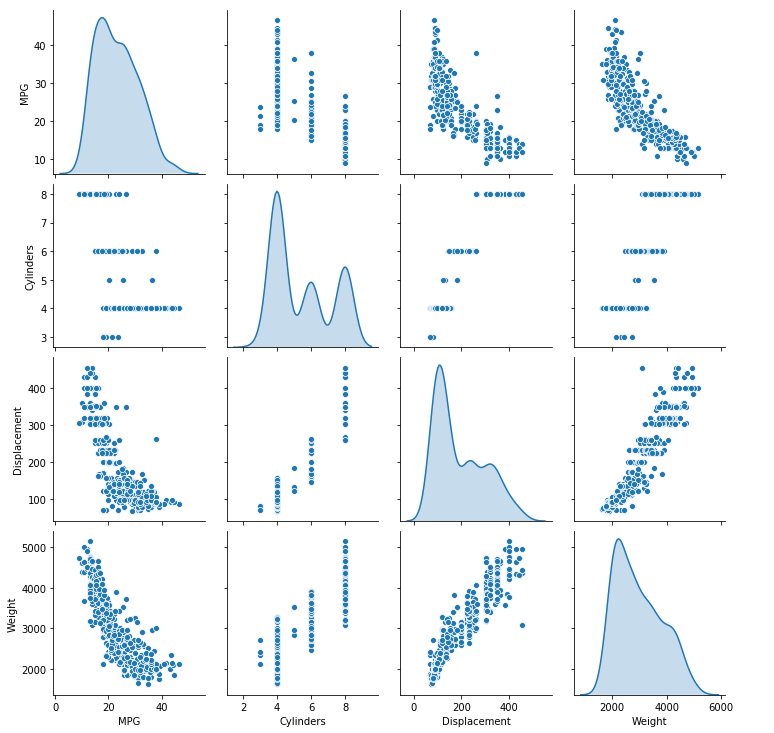

In [7]:
sns.pairplot(dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


## 통계적 수치

In [8]:
train_stats = dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.0,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.0,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.5,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.5,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.0,79.000,82.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.0,1.000,1.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.0,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.0,0.000,1.0


# 데이터 전처리
- 정답 데이터인 MPG는 훈련해야될 자질 목록에서 제외 시킨다.
- 각 자질끼리 가지는 데이터의 분포가 다르기 때문에 정규화를 시킨다.

## 정답 데이터 분리

In [9]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## 데이터 정규화

In [10]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# 딥러닝 모델 생성

In [17]:
def build_model():
    model_input = Input(shape=len(train_dataset.columns))
    hidden = Dense(64, activation='relu', name='Fully_connected_layer1')(model_input)
    hidden = Dense(64, activation='relu', name='Fully_connected_layer2')(hidden)
    model_output = Dense(1, activation='linear')(hidden)
    
    model = Model(model_input, model_output)
    
    model.summary()

    return model

In [18]:

batch_size=4
epochs=200

decay_st = (len(normed_train_data)//batch_size+1)*epochs
poly_sche = tf.keras.optimizers.schedules.PolynomialDecay(0.001, decay_st, end_learning_rate=1e-6, power=0.9)
opt_poly = tf.keras.optimizers.Adam(poly_sche)

model = build_model()
model.compile(loss='mse', optimizer=opt_poly, metrics=['mae','mse'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
Fully_connected_layer1 (Dens (None, 64)                640       
_________________________________________________________________
Fully_connected_layer2 (Dens (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


# 데이터들로 모델을 훈련
- 훈련 데이터 중 20%를 검증데이터로 사용한다.

In [ ]:
hist = model.fit(normed_train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=1, batch_size=4)

# 모델 검증

## 모델이 과적합 되었는지 확인
- 손실함수는 mse를 사용하고 측정 metrics는 mae와 mse둘다 측정한다.
- 모델 학습 결과를 보면 50 epoch 부터 훈련 데이터에 과적합 되는 모습을 볼 수 있다.

In [ ]:
# plt.figure(figsize=(20,5))
# plt.plot(hist.history['loss'][10:], label='train')
# plt.plot(hist.history['val_loss'][10:], label='valid')
# plt.title('TRAIN vs VALID (MSE)', size=20)
# plt.xlabel('epochs', size=20)
# plt.ylabel('mse', size=20)
# plt.legend(fontsize=20)
# plt.show()

In [ ]:
# plt.figure(figsize=(20,5))
# plt.plot(hist.history['mae'][10:], label='train')
# plt.plot(hist.history['val_mae'][10:], label='valid')
# plt.title('TRAIN vs VALID (MAE)', size=20)
# plt.xlabel('epochs', size=20)
# plt.ylabel('mse', size=20)
# plt.legend(fontsize=20)
# plt.show()

# 재학습 - 조기종료

In [ ]:
batch_size=4
epochs=200

decay_st = (len(normed_train_data)//batch_size+1)*epochs
poly_sche = tf.keras.optimizers.schedules.PolynomialDecay(0.001, decay_st, end_learning_rate=1e-6, power=0.9)
opt_poly = tf.keras.optimizers.Adam(poly_sche)

model = build_model()
model.compile(loss='mse', optimizer=opt_poly, metrics=['mae','mse'])

cp = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
hist = model.fit(normed_train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=1, batch_size=4, callbacks=[early_stop])

In [ ]:
# plt.figure(figsize=(20,5))
# plt.plot(hist.history['loss'][3:], label='train')
# plt.plot(hist.history['val_loss'][3:], label='valid')
# plt.title('TRAIN vs VALID (MSE)', size=20)
# plt.xlabel('epochs', size=20)
# plt.ylabel('mse', size=20)
# plt.legend(fontsize=20)
# plt.show()

In [ ]:
# plt.figure(figsize=(20,5))
# plt.plot(hist.history['mae'][3:], label='train')
# plt.plot(hist.history['val_mae'][3:], label='valid')
# plt.title('TRAIN vs VALID (MAE)', size=20)
# plt.xlabel('epochs', size=20)
# plt.ylabel('mse', size=20)
# plt.legend(fontsize=20)
# plt.show()

# 테스트 데이터로 모델 성능 최종 확인

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print('테스트 세트의 평균 절대 오차 : {:.2f} MPG'.format(mse))

## 예측과 정답의 상관도 시각화

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()
plt.figure(figsize=(10,10))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


## 오차 분포

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")